#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

**Заказчик.** Компания «Чётенькое такси»

**Цель Заказчика.** Прогнозирование количества заказов такси на следующий час для большего привлечения водителей в аэропорт в период пиковой нагрузки.

**Цель исследования.** Построить модель для прогнозирования количества заказов такси на следующий час при значение метрики RMSE на тестовой выборке не больше 48.

**Задачи:**

- Загрузить данные и выполнить их ресемплирование по одному часу.
- Проанализировать данные.
- Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
- Проверить данные на тестовой выборке и сделать выводы

**Входные данные от Заказчика.** Файл в формате .csv с данными о количестве заказов

**Ожидаемый результат.** Построена модель для предсказания количества заказов такси на следующий час, со значением метрики RMSE менее 48.

## Подготовка

**Признаки**

- `datetime` — интервал времени

**Цеоевой признак**

- `num_orders` — количество заказов

In [24]:
# Импотрт библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.random import RandomState

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from sklearn.model_selection import cross_val_score # кросс-вылидация
from sklearn.model_selection import GridSearchCV # кросс-вылидация
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler # стандартизация
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.seasonal import seasonal_decompose # Сезонность и тренд временного ряда


In [25]:
# Прочитаем файл и переведем временной ряд в индекс 
try:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
    
except FileNotFoundError:
    df = pd.read_csv('C:\\Users\\Aser\\Первый ноутбук\\Projects\\data\\taxi.csv', 
                     index_col=[0], parse_dates=[0])

df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [26]:
# Проверим временной ряд на монотонность
df.index.is_monotonic

True

In [27]:
# Выполним ресемплированиеданных по одному часу

df = df.resample('1H').sum()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


**Выводы**

В предложенном файле временной рад монотонные, что не требует дополнительно сортировки. Ресемплирование проведено по интервалу в 1 час

## Анализ

In [28]:
# Изучим данные методом info
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


<Figure size 504x720 with 0 Axes>

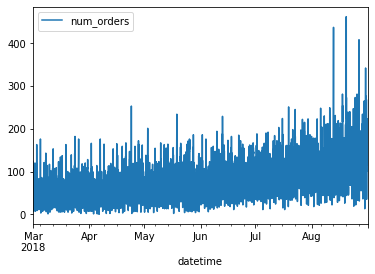

In [29]:
plt.figure(figsize=(7, 10))
df.plot()
plt.show()

<AxesSubplot:xlabel='datetime'>

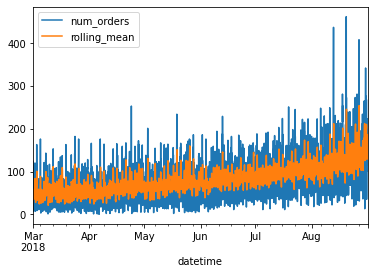

In [30]:
df['rolling_mean'] = df.rolling(7).mean()
df.plot()

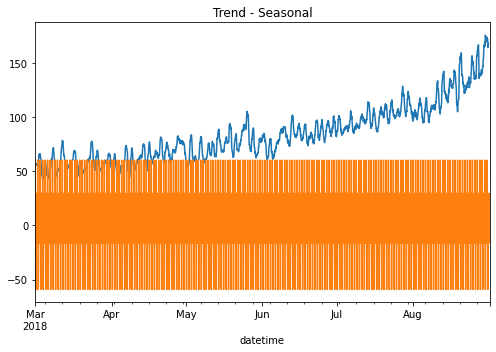

In [31]:
decomposid = seasonal_decompose(df['num_orders'])

plt.figure(figsize=(7, 5))
plt.subplot()
decomposid.trend.plot(ax=plt.gca())
decomposid.seasonal.plot(ax=plt.gca())
plt.title('Trend - Seasonal')
plt.tight_layout()

Text(0.5, 1.0, 'season_short')

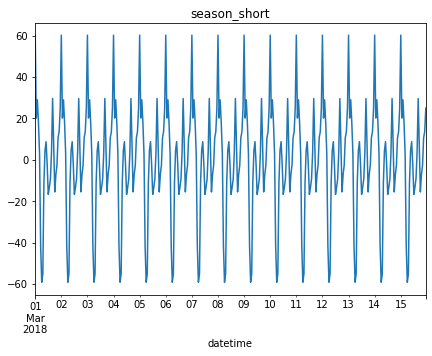

In [32]:
plt.figure(figsize=(7, 5))
plt.subplot()
decomposid.seasonal['2018-03-01':'2018-03-15'].plot(ax=plt.gca())
plt.title('season_short')

**Выводы**

Файл содержит 1 столбец с количеством заказов в течение часа. Всего 4416 строк, числового типа, без пропусков.

Графики распределения по времени и скользящей средней показывают на наличие восходящего тренда

При этом, сезонность постоянная, на коротком временном интервале видно, что ряд стационарный, из чего следует, что можно строить прогноз

## Обучение

In [33]:
# введем константу
state = RandomState(12345)

In [34]:
# Выделим тестовую выборку
train, test = train_test_split(df, test_size=.1, shuffle=False, random_state=state)

In [35]:
# Оценим качество прогноза константной моделью
pred_median = [train['num_orders'].median() for i in range(len(test['num_orders']))]
rmse_pred_median = (mean_squared_error(test['num_orders'], pred_median)) ** 0.5
print(f'Качество константной модели по RMSE {rmse_pred_median:.4f}')

Качество константной модели по RMSE 87.1528


In [36]:
# Оценим качество прогноза моделью по предыдущим значениям
pred_previous = test['num_orders'].shift(fill_value=int(train.iloc[-1, 0]))
rmse_pred_previous = (mean_squared_error(test['num_orders'], pred_previous)) ** 0.5
print(f'Качество модели по предыдущим значениям по RMSE {rmse_pred_previous:.4f}')

Качество модели по предыдущим значениям по RMSE 58.8565


In [37]:
# Уберем столбец со сколбзящей средней
df.drop(['rolling_mean'], axis=1, inplace=True)

In [38]:
# Напшем функцию создания признаков
def make_features(df, max_lag, rolling_mean_size):
    df_new = df.copy()
    df_new['month'] = df_new.index.month
    df_new['day_week'] = df_new.index.dayofweek
    df_new['day'] = df_new.index.day
    df_new['hour'] = df_new.index.hour
    
    for i in range (1, max_lag+1):
        a = 'lag_' + str(i)
        df_new[a] = df_new['num_orders'].shift(i)
    
    df_new['rolling_mean'] = df_new['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    # кодирование
    df_new = pd.get_dummies(df_new, columns=['month'], drop_first=True)
    df_new = pd.get_dummies(df_new, columns=['day_week'], drop_first=True)
    df_new = pd.get_dummies(df_new, columns=['day'], drop_first=True)
    df_new = pd.get_dummies(df_new, columns=['hour'], drop_first=True)
    
    return df_new

In [39]:
# Определим лучшие параметры методом кросс-валидации

best_rmse_reg = 1000
best_lag_reg = 0
best_roll_reg = 0

for roll in range(2, 8):
    for lag in range(2, 8):

        df_cv = make_features(df, lag, roll)
        train, test = train_test_split(df_cv, test_size=.1, shuffle=False, random_state=state)
        train = train.dropna()
        test = test.dropna()

        featere_train = np.array(train.drop(['num_orders'], axis=1))
        target_train = np.array(train['num_orders'])
        
        featere_test = test.drop(['num_orders'], axis=1)
        target_test = test['num_orders']

        rmse_list = []

        # Проверим параметры кросс-валидацией
        tscv = TimeSeriesSplit()
        for train_index, test_index in tscv.split(featere_train):
            X_train, X_test = featere_train[train_index], featere_train[test_index]
            y_train, y_test = target_train[train_index], target_train[test_index]
    
            model = LinearRegression()
            model.fit(X_train, y_train)
        
            answer = model.predict(X_test)
            rmse = (mean_squared_error(y_test, answer)) ** 0.5
            rmse_list.append(rmse)
    
        # Рассчитаем среднее качество модели
        fin_rmse = sum(rmse_list) / len(rmse_list)

        if best_rmse_reg > fin_rmse:
            best_rmse_reg = fin_rmse
            best_lag_reg = lag
            best_roll_reg = roll
        
        print(f'При количестве сдвигов {lag} и окне {roll} среднрий показатель RMSE {fin_rmse:.4f}')
        df_cv = df_cv.loc[:, ['num_orders']]
print()
print(f'Лучший средний показатель RMSE {best_rmse_reg:.4f} при количестве сдвигов {best_lag_reg} и окне {best_roll_reg}')

При количестве сдвигов 2 и окне 2 среднрий показатель RMSE 881684292775.7340
При количестве сдвигов 3 и окне 2 среднрий показатель RMSE 648707827296.1135
При количестве сдвигов 4 и окне 2 среднрий показатель RMSE 556890442070.7235
При количестве сдвигов 5 и окне 2 среднрий показатель RMSE 893410592533.0752
При количестве сдвигов 6 и окне 2 среднрий показатель RMSE 823249853757.8511
При количестве сдвигов 7 и окне 2 среднрий показатель RMSE 123962827603.6376
При количестве сдвигов 2 и окне 3 среднрий показатель RMSE 739765718000.2014
При количестве сдвигов 3 и окне 3 среднрий показатель RMSE 41908229613.7252
При количестве сдвигов 4 и окне 3 среднрий показатель RMSE 284379725128.3466
При количестве сдвигов 5 и окне 3 среднрий показатель RMSE 91485648044.9439
При количестве сдвигов 6 и окне 3 среднрий показатель RMSE 36446376889.7391
При количестве сдвигов 7 и окне 3 среднрий показатель RMSE 28.9830
При количестве сдвигов 2 и окне 4 среднрий показатель RMSE 1792841576975.5938
При количес

In [40]:
# Построим модель с лучшими праметрами
df_pred = make_features(df, best_lag_reg, best_roll_reg)

train, test = train_test_split(df_pred, test_size=.1, shuffle=False, random_state=state)
train = train.dropna()
test = test.dropna()
    
featere_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
        
featere_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']


In [41]:
best_model = None
best_rmse = 1000

In [42]:
# Построим прогноз на линейной моделе с лучшими праметрами

model_reg = LinearRegression()
model_reg.fit(featere_train, target_train)
        
answer_reg = model_reg.predict(featere_test)
rmse_reg = (mean_squared_error(target_test, answer_reg)) ** 0.5

print(f'Лучший показатель RMSE {rmse_reg:.4f} при количестве сдвигов {best_lag_reg} и окне {best_roll_reg}')

if best_rmse > rmse_reg:
    best_rmse = rmse_reg
    best_model = model_reg

Лучший показатель RMSE 44.7452 при количестве сдвигов 7 и окне 3


In [43]:
# Подберем лучшие параметры Решающего дерева методом TimeSeriesSplit

best_rmse_tree = 1000
best_depth_tree = 0

featere_train_1 = np.array(featere_train)
target_train_1 = np.array(target_train)

for dep in range(5, 16):
    rmse_list = []

    
    # Проверим параметры кросс-валидацией
    tscv = TimeSeriesSplit()
    for train_index, test_index in tscv.split(featere_train_1):
        X_train, X_test = featere_train_1[train_index], featere_train_1[test_index]
        y_train, y_test = target_train_1[train_index], target_train_1[test_index]
    
        model = DecisionTreeRegressor(max_depth=dep, random_state=state)
        model.fit(X_train, y_train)
        
        answer = model.predict(X_test)
        rmse = (mean_squared_error(y_test, answer)) ** 0.5
        rmse_list.append(rmse)
    
    # Рассчитаем среднее качество модели
    fin_rmse = sum(rmse_list) / len(rmse_list)

    if best_rmse_tree > fin_rmse:
        best_rmse_tree = fin_rmse
        best_depth_tree = dep

print(f'Лучший параметр глубины - {best_depth_tree}')

# Обучим и проверим модель с подобранными параметрами
model_tree_ok = DecisionTreeRegressor(max_depth=best_depth_tree, random_state=state)
model_tree_ok.fit(featere_train, target_train)
    
answer_tree_ok = model_tree_ok.predict(featere_test)
rmse_tree = (mean_squared_error(target_test, answer_tree_ok)) ** 0.5

print(f'Лучший показатель RMSE {rmse_tree:.4f} при глубине дерева {best_depth_tree}')

if best_rmse > rmse_tree:
    best_rmse = rmse_tree
    best_model = model_tree_ok

Лучший параметр глубины - 5
Лучший показатель RMSE 53.8281 при глубине дерева 5


In [44]:
# Подберем лучшие параметры Случайного леса методом TimeSeriesSplit

best_rmse_forest = 1000
best_est_forest = 0

for est in range(10, 61, 10):
    rmse_list = []

    # Проверим параметры кросс-валидацией
    tscv = TimeSeriesSplit()
    for train_index, test_index in tscv.split(featere_train_1):
        X_train, X_test = featere_train_1[train_index], featere_train_1[test_index]
        y_train, y_test = target_train_1[train_index], target_train_1[test_index]
    
        model = RandomForestRegressor(max_depth=best_depth_tree, n_estimators=est, random_state=state)
        model.fit(X_train, y_train)
        
        answer = model.predict(X_test)
        rmse = (mean_squared_error(y_test, answer)) ** 0.5
        rmse_list.append(rmse)
    
    # Рассчитаем среднее качество модели
    fin_rmse = sum(rmse_list) / len(rmse_list)

    if best_rmse_forest > fin_rmse:
        best_rmse_forest = fin_rmse
        best_est_forest = est

print(f'Лучший параметр числа деревьев - {best_est_forest}')

# Обучим и проверим модель с подобранными параметрами
model_forest_ok = RandomForestRegressor(max_depth=best_depth_tree, n_estimators=best_est_forest, random_state=state)
model_forest_ok.fit(featere_train, target_train)
    
answer_forest_ok = model_forest_ok.predict(featere_test)
rmse_forest = (mean_squared_error(target_test, answer_forest_ok)) ** 0.5

print(f'Лучший показатель RMSE {rmse_forest:.4f} при числе деревьев {best_est_forest}')

if best_rmse > rmse_forest:
    best_rmse = rmse_forest
    best_model = model_forest_ok

Лучший параметр числа деревьев - 60
Лучший показатель RMSE 53.3384 при числе деревьев 60


Лучший показатель RMSE **44.7452**

Достигается на датасете с **количеством сдвигов 7 и окне 3**

Достигается на моделе `Линейная регрессия`

## Тестирование

In [45]:
df_test = make_features(df, best_lag_reg, best_roll_reg)

train, test = train_test_split(df_test, test_size=.1, shuffle=False, random_state=state)
train = train.dropna()
test = test.dropna()
    
featere_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
        
featere_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

predict = best_model.predict(featere_test)
rmse = (mean_squared_error(target_test, predict)) ** 0.5

print(f'Лучшфя модель {best_model}')
print(f'На лучшей моделе достигается значение показателя RMSE {rmse:.4f}')


Лучшфя модель LinearRegression()
На лучшей моделе достигается значение показателя RMSE 44.7452


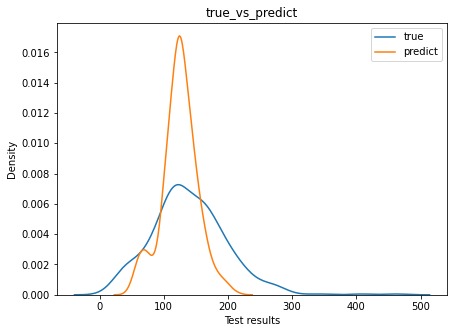

In [46]:
# Построим график сопоставлнеия реальных и прогнозных значений

plt.figure(figsize=(7, 5))
sns.kdeplot(data=list(target_test), label='true')
sns.kdeplot(data=list(predict), label='predict')
plt.xlabel("Test results")
plt.title('true_vs_predict')
plt.legend()
plt.show()

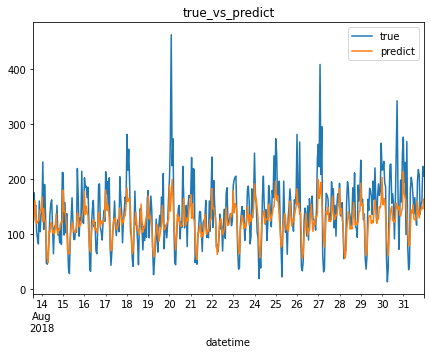

In [47]:
# Построим график временноо ряда

predict_1 = pd.Series(predict)
predict_1.index = target_test.index

plt.figure(figsize=(7, 5))
target_test.plot(label='true', legend=True)
predict_1.plot(label='predict', legend=True)
plt.title('true_vs_predict')
plt.show()

**Выводы**

Предложенная модель `Линейной регрессии` для предсказания количества заказов такси на следующий час, обеспечивает точность по метрики RMSE 44.7452

Для достижения этого показателя необходимо сформировать данные с учетом 7 сдвигов и размером окна 3 для параметра скользящее среднее

Лучший показатель достигается на моделе `Линйной регрессии`